In [251]:
import pickle
import torch
import matplotlib.pyplot as plt
import glob
import random
import pandas as pd
import numpy as np
from adabmDCA.functional import one_hot
from collections import Counter, OrderedDict

import sys
sys.path.append('..')
import utils

# %config Completer.use_jedi = True

In [44]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]
ns = range(len(experiment_ids))
ts = range(len(round_ids))

In [45]:
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/scrotti/Aptamer2025py/experiments/../utils.py'>

In [108]:
def seq_to_counts(sequences):
    seq_unique, counts = sequences.unique(dim=0, return_counts=True)
    perm = counts.argsort(descending=True)
    return seq_unique[perm], counts[perm]

def array_to_string(sequences):
    tokens = np.array(['A', 'C', 'G', 'U'])
    return np.apply_along_axis(''.join, 1, tokens[sequences])

def hamming(x, y):
    return (x != y).sum(dim=-1)

In [70]:
seq_round_zero_nonunique = [utils.sequences_from_file(experiment_ids[n], "ARN") for n in ns]

In [103]:
seq_counts_round_zero = [seq_to_counts(seq) for seq in seq_round_zero_nonunique]

In [132]:
def most_abundant(seq_counts, n=5):
    sequences, counts = seq_counts
    sequences = sequences[:n]
    counts = counts[:n]
    seq_str = array_to_string(sequences)
    df = pd.DataFrame(zip(seq_str, counts.numpy()), columns=['Sequence', 'Count'])
    return df

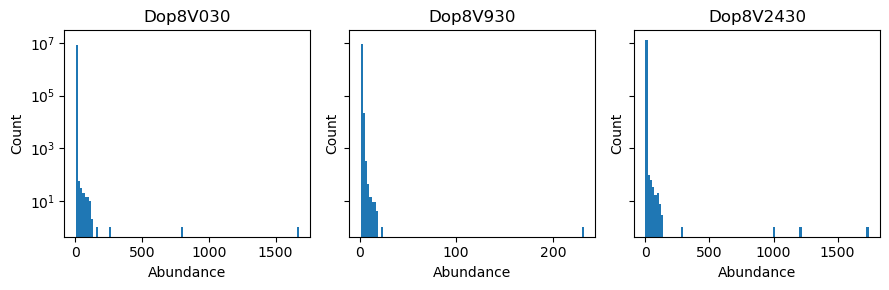

In [155]:
fig, axes = plt.subplots(1,3, figsize=(9,3), sharey=True)
for n in ns:
    seq_counts = seq_counts_round_zero[n]
    sequences, counts = seq_counts
    ax = axes[n]
    ax.hist(counts, bins=100)
    ax.set_yscale('log')
    ax.set_xlabel('Abundance')
    ax.set_ylabel('Count')
    ax.set_title(experiment_ids[n])
plt.tight_layout()

## Most abundant sequences

In [157]:
for n in ns:
    seq_counts = seq_counts_round_zero[n]
    print(experiment_ids[n])
    print(most_abundant(seq_counts))
    print()

Dop8V030
                                        Sequence  Count
0  AUGGAACCCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG   1674
1  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGCCA    795
2  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGGCA    253
3  AUGGAACUCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    152
4  AUGGAACCCCGACAUCUACGUGCGGUGUACAGACAUCUGAUGUCG    133

Dop8V930
                                        Sequence  Count
0  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCCGCAGCCG    232
1  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCAGCAGCCG     22
2  GACAUCAUACAUGUCGAACAGCUUUCUAACGGAGCCCCGCAGCCG     19
3  GACGUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCCGCAGCCG     18
4  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGACCCGCAGCCG     18

Dop8V2430
                                        Sequence  Count
0  AUGGAACCCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG   1742
1  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCCGCAGCCG   1209
2  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGCCA   1000
3  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGGCA    292
4  AUGGAACCCCGACAU

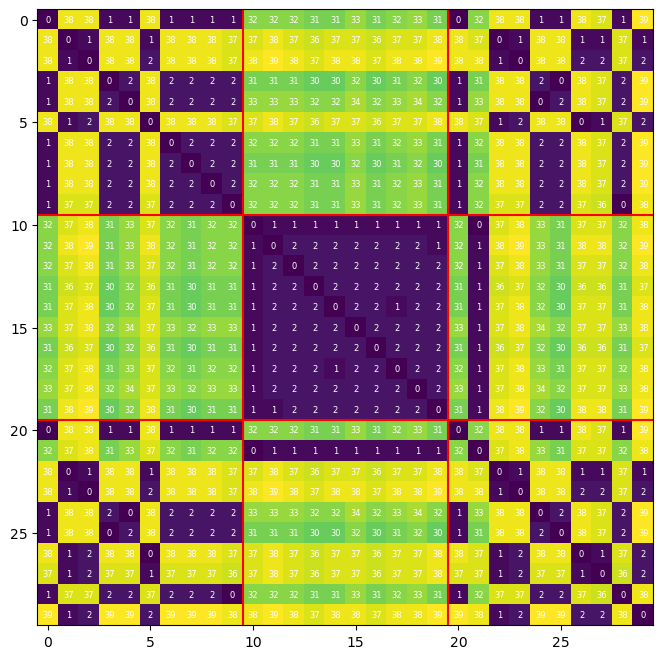

In [349]:
M = 10
mat = torch.zeros(3, M, 3, M, dtype=int)
for m in ns:
    for i in range(M):
        for n in ns:
            for j in range(M):
                d = hamming(seq_counts_round_zero[m][0][i], seq_counts_round_zero[n][0][j])
                mat[m,i,n,j] = d
                
mat_resh = mat.reshape(3*M,3*M)
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(mat_resh, origin='upper')
for i in range(1, len(ns)):
    ax.axvline(x=i*M-0.5, color="red")
    ax.axhline(y=i*M-0.5, color="red")

for i in range(3*M):
    for j in range(3*M):
        text = ax.text(j, i, mat_resh[i, j].item(),
                       ha="center", va="center", color="w", fontsize=6)

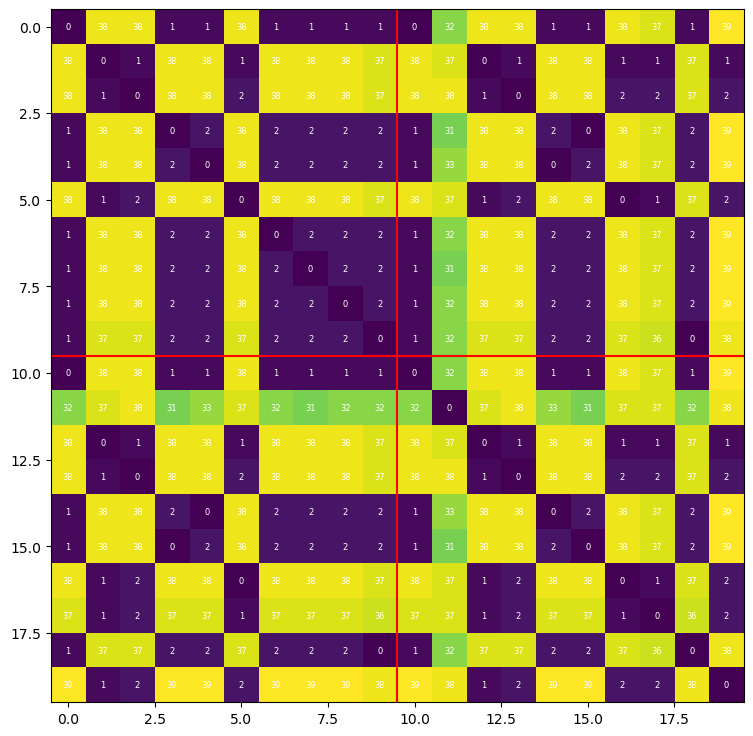

In [342]:
M = 10
mat = torch.zeros(2, M, 2, M, dtype=int)
ns_ = [0,2]
for m in range(2):
    for i in range(M):
        for n in range(2):
            for j in range(M):
                d = hamming(seq_counts_round_zero[ns_[m]][0][i], seq_counts_round_zero[ns_[n]][0][j])
                mat[m,i,n,j] = d
                
mat_resh = mat.reshape(2*M,2*M)
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(mat_resh, origin='upper')
for i in range(1, len(ns_)):
    ax.axvline(x=i*M-0.5, color="red")
    ax.axhline(y=i*M-0.5, color="red")

for i in range(2*M):
    for j in range(2*M):
        text = ax.text(j, i, mat_resh[i, j].item(),
                       ha="center", va="center", color="w", fontsize=6)

## Wildtypes

### Guess wildtype from counts

In [225]:
wt_counts = [seq_counts_round_zero[n][0][0] for n in ns]

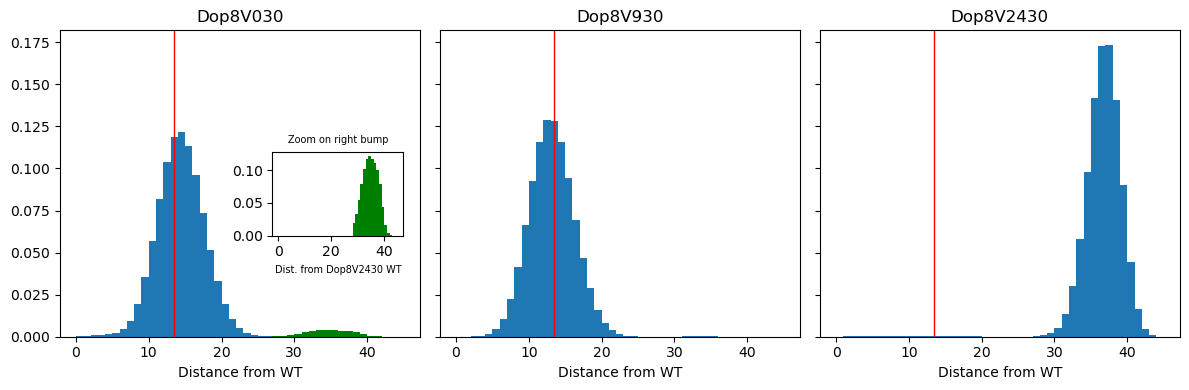

In [361]:
distances_counts = [hamming(wt_counts[n], seq_counts_round_zero[n][0]) for n in ns]
thresh = 27

fig, axes = plt.subplots(1,3, figsize=(12, 4), 
                        sharex=True, sharey=True
                        )
for n in ns:
    ax = axes[n]
    N, bins, patches = ax.hist(distances_counts[n], bins=range(46), density=True, 
            weights=seq_counts_round_zero[n][1]
           )
    ax.axvline(x=0.3*45, color="red", linewidth=1)
    ax.set_title(experiment_ids[n])
    ax.set_xlabel('Distance from WT')

    if n == 0:
        for i in range(thresh, 45):
            patches[i].set_facecolor('g')
        axin = ax.inset_axes((27, 0.06, 18, 0.05), transform=ax.transData)
        idx = distances_sites[n] > thresh
        distances_cross = hamming(wt_counts[2-n], seq_counts_round_zero[n][0][idx])
        axin.hist(distances_cross, density=True, bins=range(46), color='g')
        axin.set_title('Zoom on right bump', fontsize=7)
        axin.set_xlabel(f'Dist. from {experiment_ids[2-n]} WT', fontsize=7)
        
plt.tight_layout()

In [346]:
def most_abundant_with_distance(seq_counts, wt, n=5):
    sequences, counts = seq_counts
    sequences = sequences[:n]
    counts = counts[:n]
    seq_str = array_to_string(sequences)
    dist = hamming(wt, sequences).numpy()
    df = pd.DataFrame(zip(seq_str, counts.numpy(), dist), columns=['Sequence', 'Count', 'Dist. from WT'])
    return df

for n in ns:
    seq_counts = seq_counts_round_zero[n]
    print(experiment_ids[n])
    print(most_abundant_with_distance(seq_counts, wt_counts[n], 10))
    print()

Dop8V030
                                        Sequence  Count  Dist. from WT
0  AUGGAACCCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG   1674              0
1  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGCCA    795             38
2  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGGCA    253             38
3  AUGGAACUCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    152              1
4  AUGGAACCCCGACAUCUACGUGCGGUGUACAGACAUCUGAUGUCG    133              1
5  CGAGAUGAGAUGUCGGCCCACAGAUAACGGUCGAGGACCAUGCCA    129             38
6  AUGGAACCCCGACAUCUACGUUCGGUGAACAGACAUCUGAUGUCG    117              1
7  AUGGAACCCCGUCAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    117              1
8  AUGGAAUCCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    112              1
9  AUGGAACCCCGAUAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    110              1

Dop8V930
                                        Sequence  Count  Dist. from WT
0  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCCGCAGCCG    232              0
1  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCAGCAGCCG     22   

### Guess wildtype from single-site frequencies

In [270]:
def guess_wt_sites(seq_counts):
    seq, counts = seq_counts
    seq_oh = one_hot(seq)
    seq_oh_weighted = seq_oh * counts[:,None,None]
    fi = seq_oh_weighted.mean(dim=0)
    wt = fi.argmax(dim=1)
    return wt

In [271]:
wt_sites = [guess_wt_sites(seq_counts_round_zero[n]) for n in ns]

In [328]:
for n in ns:
    yn = wt_sites[n] in seq_counts_round_zero[n][0]
    yn_str = ' '
    if not yn:
        yn_str = ' not '
    print(f'The WT guessed from site counts for dataset {experiment_ids[n]} is{yn_str}present in the dataset')

The WT guessed from site counts for dataset Dop8V030 is present in the dataset
The WT guessed from site counts for dataset Dop8V930 is present in the dataset
The WT guessed from site counts for dataset Dop8V2430 is present in the dataset


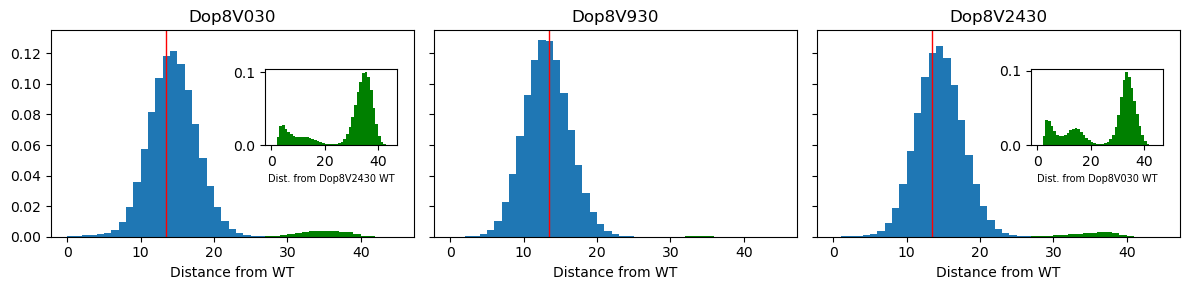

In [314]:
distances_sites = [hamming(wt_sites[n], seq_counts_round_zero[n][0]) for n in ns]

thresh = 27

fig, axes = plt.subplots(1,3, figsize=(12,3), sharex=True, sharey=True)
for n in ns: 
    ax = axes[n]
    N, bins, patches = ax.hist(distances_sites[n], bins=range(46), density=True, 
            weights=seq_counts_round_zero[n][1]
           )
    for i in range(thresh, 45):
        patches[i].set_facecolor('g')
    ax.axvline(x=0.3*45, color="red", linewidth=1)
    ax.set_title(experiment_ids[n])
    ax.set_xlabel('Distance from WT')

    if n in [0,2]:
        axin = ax.inset_axes((27, 0.06, 18, 0.05), transform=ax.transData)
        idx = distances_sites[n] > thresh
        distances_cross = hamming(wt_sites[2-n], seq_counts_round_zero[n][0][idx])
        axin.hist(distances_cross, density=True, bins=range(46), color='g')
        # axin.set_title('Zoom on right bump', fontsize=7)
        axin.set_xlabel(f'Dist. from {experiment_ids[2-n]} WT', fontsize=7)
plt.tight_layout()

In [348]:
# fig, axes = plt.subplots(3,3, figsize=(6,6), sharex=True, sharey=True)
# for m in ns:
#     for n in ns:
#         if m != n:
#             ax = axes[m,n]
#             d = hamming(wt_sites[n], seq_counts_round_zero[m][0])
#             ax.hist(d, bins=range(46), density=True)
#             ax.set_xlabel(f'Distance from WT {experiment_ids[n]}', fontsize=8)
#             ax.set_title(f'Sequences from {experiment_ids[m]}', fontsize=8)
# plt.tight_layout()

In [347]:
for n in ns:
    seq_counts = seq_counts_round_zero[n]
    print(experiment_ids[n])
    print(most_abundant_with_distance(seq_counts, wt_sites[n], 10))
    print()

Dop8V030
                                        Sequence  Count  Dist. from WT
0  AUGGAACCCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG   1674              0
1  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGCCA    795             38
2  CGAGAUGAGAUGUCGGCCCACAGCUAACGGUCGAGGACCAUGGCA    253             38
3  AUGGAACUCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    152              1
4  AUGGAACCCCGACAUCUACGUGCGGUGUACAGACAUCUGAUGUCG    133              1
5  CGAGAUGAGAUGUCGGCCCACAGAUAACGGUCGAGGACCAUGCCA    129             38
6  AUGGAACCCCGACAUCUACGUUCGGUGAACAGACAUCUGAUGUCG    117              1
7  AUGGAACCCCGUCAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    117              1
8  AUGGAAUCCCGACAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    112              1
9  AUGGAACCCCGAUAUCUACGUGCGGUGAACAGACAUCUGAUGUCG    110              1

Dop8V930
                                        Sequence  Count  Dist. from WT
0  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCCGCAGCCG    232              0
1  GACAUCAUACAUGUCGAACAGCUUUCCAACGGAGCCCAGCAGCCG     22   